In [1]:
import sys
sys.path.insert(0, '..')

from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [3]:
batches = []
iter_trainloader = iter(trainloader)
for i in range(10):
    b, _ = next(iter_trainloader)
    batches.append(b)

In [18]:
coco_trainset = torchvision.datasets.ImageFolder(root='../data/coco', transform=transform)
coco_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
coco_batches = []
coco_iter_trainloader = iter(coco_trainloader)
for i in range(10):
    b, _ = next(coco_iter_trainloader)
    coco_batches.append(b)

In [4]:
resnet = models.resnet50(pretrained=True).eval().cuda()
resnet_attn = torch.load('../4-29-Top3/new_attn.pkl').eval().cuda()

In [5]:
def get_pre_fc(network, batches):
    res50_pre_pool_outs = []
    for batch in batches:
        out = Variable(batch).cuda()
        for i, layer in enumerate(list(network.children())):
            if isinstance(layer, torch.nn.modules.linear.Linear):
                out = out.view(out.size(0), -1)
            out = layer(out)
            if i == 8:
                res50_pre_pool_outs.append(out.squeeze().data.cpu().numpy())
                break
    return np.vstack(res50_pre_pool_outs)

In [6]:
resnet_result = get_pre_fc(resnet, batches)
resnet_attn_result = get_pre_fc(resnet_attn, batches)

In [26]:
centroid = resnet_result.mean(0).reshape(1,-1)
attn_centroid = resnet_attn_result.mean(0).reshape(1,-1)

(array([ 9., 62., 88., 70., 52., 21., 12.,  5.,  0.,  1.]),
 array([120.41699982, 169.70419388, 218.99138794, 268.278582  ,
        317.56577606, 366.85297012, 416.14016418, 465.42735825,
        514.71455231, 564.00174637, 613.28894043]),
 <a list of 10 Patch objects>)

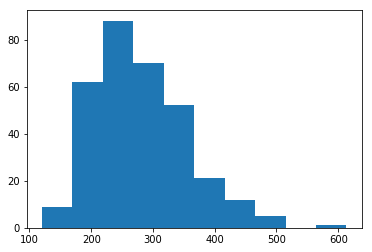

In [34]:
plt.hist(((resnet_result - centroid)**2).sum(axis=1))

(array([ 59., 135.,  83.,  33.,   5.,   4.,   0.,   0.,   0.,   1.]),
 array([ 985.76184082, 1619.96885986, 2254.17587891, 2888.38289795,
        3522.58991699, 4156.79693604, 4791.00395508, 5425.21097412,
        6059.41799316, 6693.62501221, 7327.83203125]),
 <a list of 10 Patch objects>)

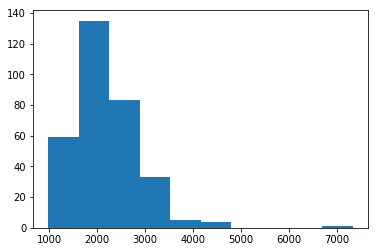

In [35]:
plt.hist(((resnet_attn_result - attn_centroid)**2).sum(axis=1))

In [29]:
coco_centroid = coco_resnet_result.mean(0).reshape(1,-1)
coco_attn_centroid = coco_resnet_attn_result.mean(0).reshape(1,-1)

In [30]:
((coco_resnet_result - coco_centroid)**2).sum()

87091.96

In [33]:
((coco_resnet_attn_result - coco_attn_centroid)**2).sum(axis=1).shape

(320,)

In [19]:
coco_resnet_result = get_pre_fc(resnet, coco_batches)
coco_resnet_attn_result = get_pre_fc(resnet_attn, coco_batches)

In [9]:
resnet_result.shape

(320, 2048)

In [10]:
resnet_attn_result.shape

(320, 2048)

In [11]:
from sklearn.manifold import TSNE

In [12]:
data = np.vstack([resnet_result, resnet_attn_result])

In [20]:
coco_data = np.vstack([coco_resnet_result, coco_resnet_attn_result])

In [24]:
embed = TSNE().fit_transform(np.vstack([data, coco_data]))

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

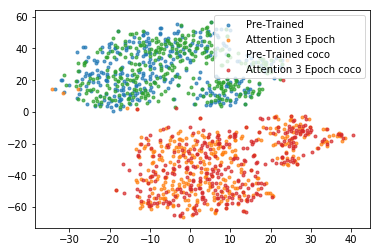

In [25]:
plt.scatter(embed[:320,0], embed[:320,1], marker='.', alpha=0.7, label='Pre-Trained')
plt.scatter(embed[320:640,0], embed[320:640,1], marker='.', alpha=0.7, label='Attention 3 Epoch')
plt.scatter(embed[640:960,0], embed[640:960,1], marker='.', alpha=0.7, label='Pre-Trained coco')
plt.scatter(embed[960:,0], embed[960:,1], marker='.', alpha=0.7, label='Attention 3 Epoch coco')
plt.legend()